# Deep Hedging revisited

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [35]:
# Set the device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the seaborn plotting theme
sns.set_theme()
plt.rcParams["figure.figsize"] = (15,7)

### Examples of path generators

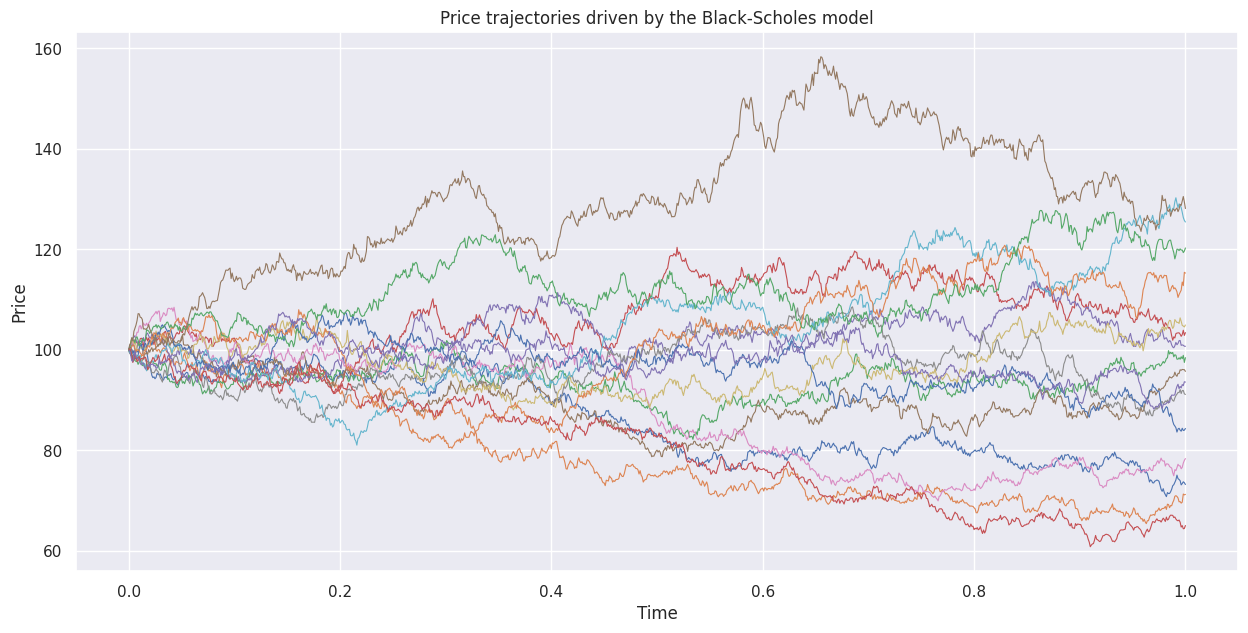

In [30]:
# The Black-Scholes model

from deephedging.generators import BlackScholesGenerator

# Set parameters
S0 = 100                # Initial stock price
r = 0.05                # Risk-free interest rate
sigma = 0.2             # Volatility
T = 1                   # Time horizon
N = 1000                # Number of time steps
batch_size = 16         # Number of paths in each batch
num_batches = 100       # Number of batches to generate

# Generate paths
BS_generator = BlackScholesGenerator(S0, r, sigma, T, N, batch_size,
                                     num_batches, DEVICE)
example_paths = next(BS_generator)

# Plot paths
plt.plot(np.linspace(0,1,num=N+1), example_paths.T, alpha=1, linewidth=0.8)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Price trajectories driven by the Black-Scholes model")
plt.show()

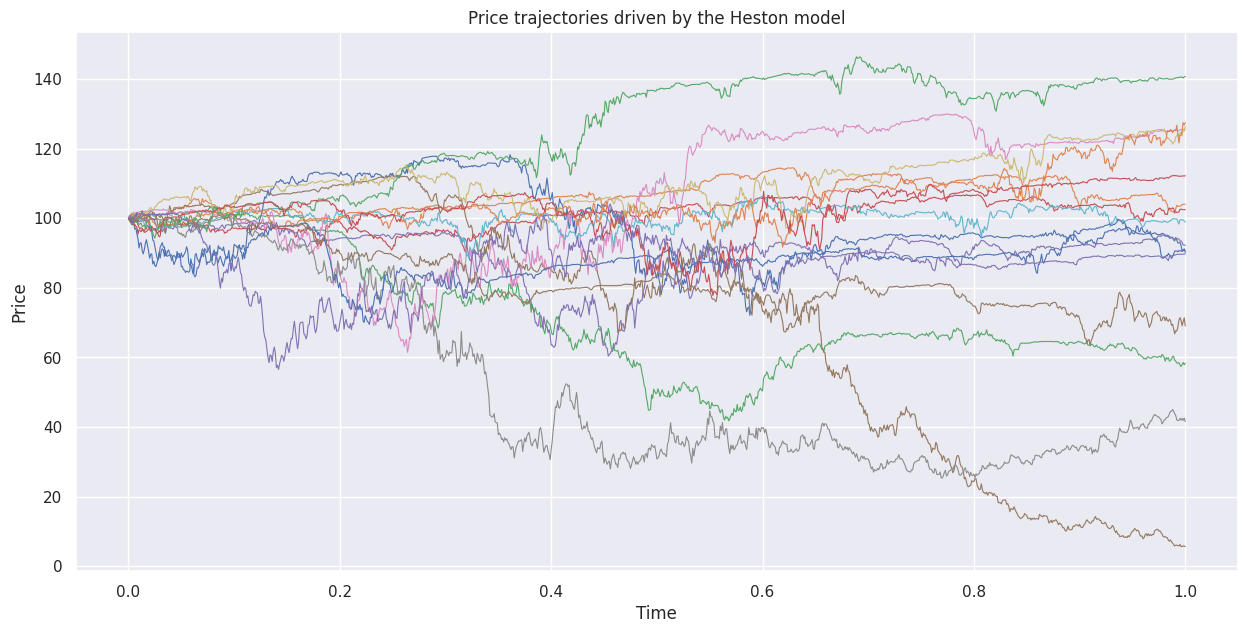

In [36]:
# The Heston stochastic volatility model

from deephedging.generators import HestonGenerator

# Set parameters
S0 = 100              # the initial asset price
v0 = 0.04             # the initial volatility
r = 0                 # the risk-free rate
theta = 0.04          # the long-term price variance
kappa = 1             # the rate of reversion to theta
xi = 2                # the volatility of sqrt(V_t)  
rho = -0.7            # the correlation of Brownian motions
T = 1                 # Time period
N = 1000              # Number of trading days
num_batches = 100     # Number of batches
batch_size = 16       # Number of paths in each batch

# Generate paths
Heston_generator = HestonGenerator(S0, v0, r, theta, kappa, xi, rho, T, N,
                                   batch_size, num_batches, DEVICE)
example_paths = next(Heston_generator)

# Plot paths
plt.plot(np.linspace(0,1,num=N+1), example_paths.T, alpha=1, linewidth=0.8)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Price trajectories driven by the Heston model")
plt.show()

### Hedging in the Black-Scholes model

In [37]:
# Initialize the Black-Scholes path generator

# Set model parameters
S0 = 100                # Initial stock price
r = 0.05                # Risk-free interest rate
sigma = 0.2             # Volatility
T = 1                   # Time horizon
N = 1000                # Number of time steps
batch_size = 16         # Number of paths in each batch
num_batches = 100       # Number of batches to generate

BS_generator = BlackScholesGenerator(S0, r, sigma, T, N, batch_size,
                                     num_batches, DEVICE)

50it [00:28,  1.77it/s]


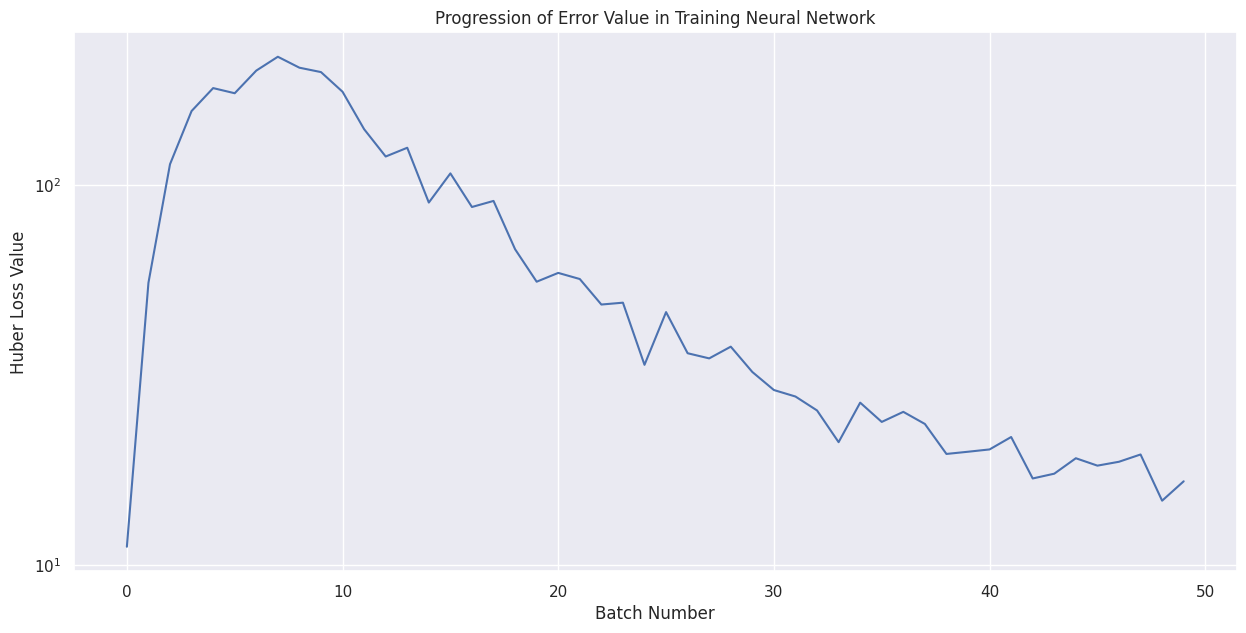

In [33]:
from deephedging.hedging import FeedForwardHedgingStrategy
from deephedging.option_pricing import get_european_call_price

# Parameters for the strategy neural network
hidden_nodes = 100    # Number of hidden nodes in the neural network
# batch_size = 5000     # Number of paths in each batch
batch_size = 100      # Number of paths in each batch
# num_batches = 200     # Number of batches
num_batches = 50      # Number of batches
lr = 0.05             # Learning rate


# Initialize the hedging strategy
errors = []
loss = nn.HuberLoss()
strategy = FeedForwardHedgingStrategy(hidden_nodes, N)
optimizer = optim.Adam(strategy.parameters(), lr=lr)
BS_generator = BlackScholesGenerator(S0, r, sigma, T, N, batch_size,
                                     num_batches, DEVICE)

# Train the hedging neural networks
for S in tqdm(BS_generator):
    optimizer.zero_grad()
    error = loss(strategy(S)[0], get_european_call_price(S[:,-1], S0))
    errors.append(error.item())
    error.backward()
    optimizer.step()

# Plot the evolution of the error value
fig, ax = plt.subplots()
ax.set_yscale('log')
plt.plot(np.array(errors))
plt.xlabel("Batch Number")
plt.ylabel("Huber Loss Value")
plt.title("Progression of Error Value in Training Neural Network")
plt.show()